# Imports and Configuration

In [ ]:
!unzip /content/feature_engineering.zip

Archive:  /content/feature_engineering.zip
  inflating: DataDocumentation.txt   
  inflating: abalone.csv             
  inflating: accidents.csv           
  inflating: airbnb.csv              
  inflating: ames.csv                
  inflating: autos.csv               
  inflating: bike-sharing.csv        
  inflating: caravan.csv             
  inflating: concrete.csv            
  inflating: customer.csv            
  inflating: housing.csv             
  inflating: movielens1m.csv         
  inflating: spotify.csv             
  inflating: feature_engineering_housing/data_description.txt  
  inflating: feature_engineering_housing/sample_submission (1).csv  
  inflating: feature_engineering_housing/test.csv  
  inflating: feature_engineering_housing/train.csv  


In [ ]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import warnings



plt.style.use("seaborn-whitegrid")

plt.rc("figure", autolayout=True)

plt.rc(

    "axes",

    labelweight="bold",

    labelsize="large",

    titleweight="bold",

    titlesize=14,

    titlepad=10,

)

warnings.filterwarnings('ignore')



In [ ]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype


from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

# Data Preprocessing

In [ ]:
def load_data():
    data_dir = Path("/content/feature_engineering_housing")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    df = pd.concat([df_train, df_test])
    df = clean(df)

    df = impute(df)
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


In [ ]:
data_dir = Path("/content/feature_engineering_housing")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [ ]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [ ]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

# Load Data

In [ ]:
df_train, df_test = load_data()

In [ ]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
   log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: nan RMSLE


# Feature Utility Scores

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

In [ ]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

nan

# Create Features

In [ ]:
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    return X

In [ ]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [ ]:
def mathematical_transforms(df):
    X = pd.DataFrame()
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd

    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X

def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [ ]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new
def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)

    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [ ]:
def apply_pca(X, standardize=True):

    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(X)

    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )
    return pca, X_pca, loadings
def plot_variance(pca, width=8, dpi=100):

    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs

In [ ]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

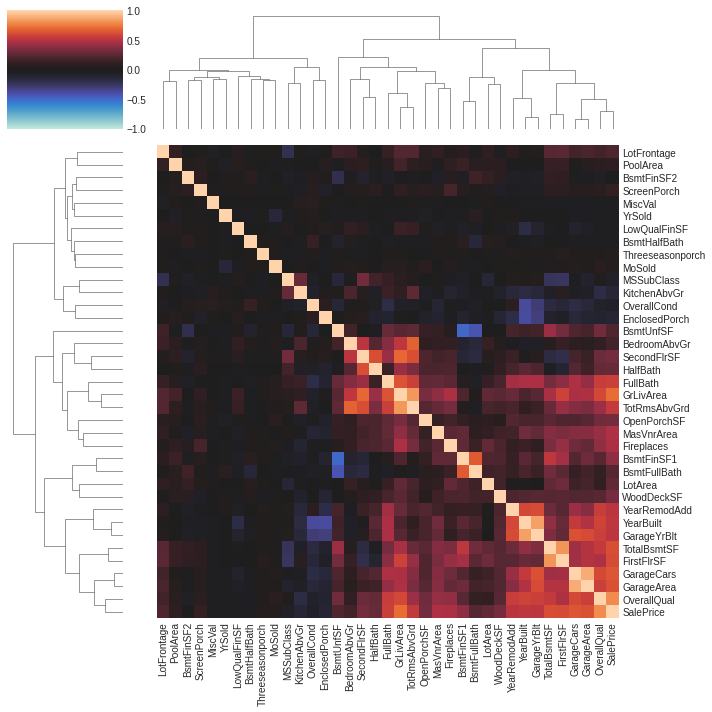

In [ ]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)


In [ ]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

In [ ]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs
        self.cv_ = KFold(n_splits=5)

    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
             ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [ ]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    X = drop_uninformative(X, mi_scores)
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))

    X = X.join(group_transforms(X))

    X = X.join(pca_inspired(X))

    X = label_encode(X)
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)


    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

nan

In [ ]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=1000,
    min_child_weight=1,
    colsample_bytree=0.7,
    subsample=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    num_parallel_tree=1,
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

nan

In [ ]:
pip install --upgrade optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2023-02-26 16:40:56,445] A new study created in memory with name: no-name-149d245e-76e4-44ea-be45-4dcac2e404e0
[W 2023-02-26 16:40:56,539] Trial 0 failed with parameters: {'max_depth': 10, 'learning_rate': 0.03949451327278244, 'n_estimators': 4395, 'min_child_weight': 4, 'colsample_bytree': 0.9072144697815385, 'subsample': 0.22157016004489344, 'reg_alpha': 0.013232334488846366, 'reg_lambda': 0.512360809562926} because of the following error: The value nan is not acceptable..
[W 2023-02-26 16:40:56,546] Trial 0 failed with value nan.
[W 2023-02-26 16:40:56,597] Trial 1 failed with parameters: {'max_depth': 8, 'learning_rate': 0.021761209309805088, 'n_estimators': 4001, 'min_child_weight': 5, 'colsample_bytree': 0.8434892138178436, 'subsample': 0.9446662001269617, 'reg_alpha': 0.006220651315401329, 'reg_lambda': 0.0003081117177836496} because of the following error: The value nan is not acceptable..
[W 2023-02-26 16:40:56,607] Trial 1 failed with value nan.
[W 2023-02-26 16:40:56,661]

ValueError: ignored

In [ ]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

print("Your submission was successfully saved!")

Your submission was successfully saved!
